weaves - Revolut Challenge

This notebook provides analysis for Part II - Engagedness measurement

It uses a local module rvlt

In [192]:
import numpy as np
import pandas as pd
import math

import scipy.stats as st
import statsmodels as sm
import statsmodels.api as smi

import matplotlib
from cycler import cycler
import matplotlib.pyplot as plt

import rvlt

%load_ext autoreload
%autoreload 2

pd.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'0.24.2'

In [2]:
# If you turn this feature on, you can display each result as it happens.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [144]:
# Tables to fetch from q/kdb+
tbls = ("ttdays0", "users2", "ntfs0", "ntfs1" )

In [145]:
# URL build function
urlf = lambda x: str.format("http://j1:4444/q.csv?{}", x)

In [146]:
# example
c = pd.read_csv(urlf(tbls[0]))
c.head()

,tdays0,x
0,1,176
1,2,939
2,3,1021
3,4,902
4,5,875


In [147]:
# List for Excel - use text import and pass the URL as the filename (don't use web import)
[ urlf(x) for x in tbls]

['http://j1:4444/q.csv?ttdays0',
 'http://j1:4444/q.csv?users2',
 'http://j1:4444/q.csv?ntfs0',
 'http://j1:4444/q.csv?ntfs1']

In [149]:
# Try and fit tdays0 to a distribution
c = pd.read_csv(urlf(tbls[0]))
c.head()
data = pd.Series(c['x'], index=c['tdays0'])
data = pd.Series(c['x'])
data.head()
len(data)
all(data > 0.5)

,tdays0,x
0,1,176
1,2,939
2,3,1021
3,4,902
4,5,875


0     176
1     939
2    1021
3     902
4     875
Name: x, dtype: int64

604

True

<Figure size 864x576 with 0 Axes>

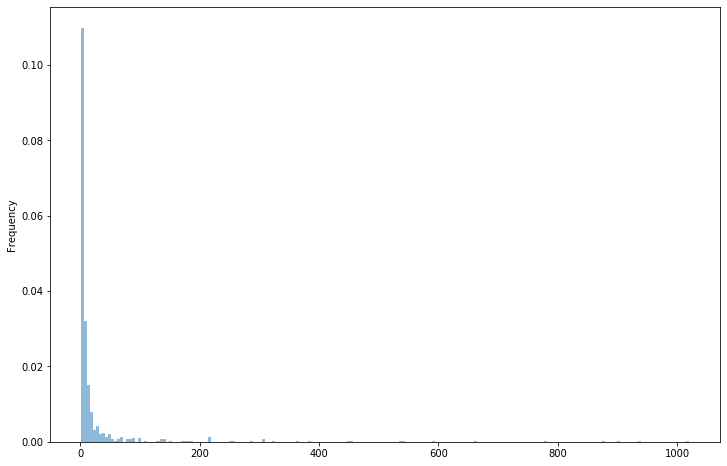

In [150]:
# Plot for comparison
bins=math.floor(len(data)/3)

plt.figure(figsize=(12,8))
data.plot(kind='hist', bins=bins, density=True, alpha=0.5)

In [187]:
distribution = st.pareto # 0.004500105346672364
distribution = st.weibull_min # 0.026744602482763516
distribution = st.weibull_max # 0.11059876836774153
distribution = st.wald # 0.04321951887147501 good shape 0.004286143389295488
distribution = st.pareto # 0.004500105346672364 0.00030974282763696146 0.0004970887541559099
distribution = st.invgauss # 0.0042553838908376595 0.0003295758342573526 0.00029231504502302705 0.0006448498305976865
distribution = st.invweibull # 0.08741126234883718 0.00019755557973632042
distribution = st.genextreme # 0.04823740732286759 0.00019752473779033813
distribution = st.loglaplace # 0.013750924203496164 0.00011770092369544237
# distribution = 

params = (0.0, 1.0)
sse = np.inf

In [188]:
# fit dist to data
params = distribution.fit(data)

# Separate parts of parameters
arg = params[:-2]
loc = params[-2]
scale = params[-1]
(arg, loc, scale)

/misc/share/0/anaconda3/envs/gensim/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4339: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/misc/share/0/anaconda3/envs/gensim/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/misc/share/0/anaconda3/envs/gensim/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4330: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)


((0.6782624644390982,), 0.9999999999999999, 3.159519642223903)

In [189]:
y, x = np.histogram(data, bins=bins, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

# Calculate fitted PDF and error with fit in distribution
pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
sse = np.sum(np.power(y - pdf, 2.0))
sse

0.00011770092369544237

In [190]:
pdf = make_pdf(distribution, params)

<Figure size 864x576 with 0 Axes>

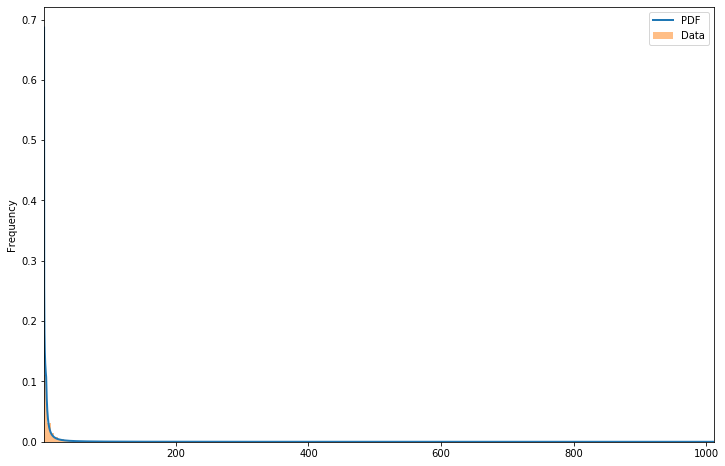

In [190]:
# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=bins, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

In [191]:
params

(0.6782624644390982, 0.9999999999999999, 3.159519642223903)

In [38]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf